In [2]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
#from aif360.datasets import autismDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
#from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions
from aif360.explainers import MetricTextExplainer
from aif360.explainers import MetricJSONExplainer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from collections import Counter
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.sklearn import metrics

#from common_utils import compute_metrics

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]



#Load the data
autism_data = pd.read_csv('C:/Users/thano/Υπολογιστής/ΠΤΥΧΙΑΚΗ/DATASETS/Autism-Adult-Data.csv',sep= ',', header= 0)

In [3]:
print ("Dataset Lenght:: ", len(autism_data))
print ("Dataset Shape:: ", autism_data.shape)
#autism_data.sample(50)


print ("Rows     : " ,autism_data.isnull().shape[0])
print ("Columns  : " ,autism_data.isnull().shape[1])
print ("\nMissing values :  ", autism_data.isnull().sum().values.sum())



Dataset Lenght::  704
Dataset Shape::  (704, 22)
Rows     :  704
Columns  :  22

Missing values :   0


In [4]:
# rename the other values except White value in race column as Other
autism_data['ethnicity']= autism_data['ethnicity'].replace(['Black','Asian','Middle-Eastern','Middle Eastern ','Middle Eastern','Pasifika', 'others','South Asian', 'Latino', 'Turkish','Hispanic','Others'], 'Other')
autism_data.head(20)

,id,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,1,0,0,1,1,0,...,f,White-European,no,no,United States,no,6,18 and more,Self,NO
1,2,1,1,0,1,0,0,0,1,0,...,m,Other,no,yes,Brazil,no,5,18 and more,Self,NO
2,3,1,1,0,1,1,0,1,1,1,...,m,Other,yes,yes,Spain,no,8,18 and more,Parent,YES
3,4,1,1,0,1,0,0,1,1,0,...,f,White-European,no,yes,United States,no,6,18 and more,Self,NO
4,5,1,0,0,0,0,0,0,1,0,...,f,White-European,no,no,Egypt,no,2,18 and more,?,NO
5,6,1,1,1,1,1,0,1,1,1,...,m,Other,yes,no,United States,no,9,18 and more,Self,YES
6,7,0,1,0,0,0,0,0,1,0,...,f,Other,no,no,United States,no,2,18 and more,Self,NO
7,8,1,1,1,1,0,0,0,0,1,...,m,White-European,no,no,New Zealand,no,5,18 and more,Parent,NO
8,9,1,1,0,0,1,0,0,1,1,...,m,White-European,no,no,United States,no,6,18 and more,Self,NO
9,10,1,1,1,1,0,1,1,1,1,...,m,Other,yes,yes,Bahamas,no,8,18 and more,Health care professional,YES


In [5]:
autism_data = autism_data[['age','gender','ethnicity','jundice','austim','contry_of_res','used_app_before','result','age_desc','Class/ASD','relation']]
autism_data.head()

,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,Class/ASD,relation
0,26,f,White-European,no,no,United States,no,6,18 and more,NO,Self
1,24,m,Other,no,yes,Brazil,no,5,18 and more,NO,Self
2,27,m,Other,yes,yes,Spain,no,8,18 and more,YES,Parent
3,35,f,White-European,no,yes,United States,no,6,18 and more,NO,Self
4,40,f,White-European,no,no,Egypt,no,2,18 and more,NO,?


In [6]:
autism_data = autism_data.replace('?', np.nan)
autism_data.head()

,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,Class/ASD,relation
0,26,f,White-European,no,no,United States,no,6,18 and more,NO,Self
1,24,m,Other,no,yes,Brazil,no,5,18 and more,NO,Self
2,27,m,Other,yes,yes,Spain,no,8,18 and more,YES,Parent
3,35,f,White-European,no,yes,United States,no,6,18 and more,NO,Self
4,40,f,White-European,no,no,Egypt,no,2,18 and more,NO,NaN


In [7]:
# select all categorical variables
autism_data_categorical = autism_data.select_dtypes(include=['object'])
autism_data_categorical.head()

,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
0,26,f,White-European,no,no,United States,no,18 and more,NO,Self
1,24,m,Other,no,yes,Brazil,no,18 and more,NO,Self
2,27,m,Other,yes,yes,Spain,no,18 and more,YES,Parent
3,35,f,White-European,no,yes,United States,no,18 and more,NO,Self
4,40,f,White-European,no,no,Egypt,no,18 and more,NO,NaN


In [8]:
#label encoding for categorical values but not for missing values
le = preprocessing.LabelEncoder()
autism_data_categorical = autism_data_categorical.apply(lambda series: pd.Series(le.fit_transform(series[series.notnull()]),index=series[series.notnull()].index))
autism_data_categorical.head()

,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
0,9.0,0,1,0,0,64,0,0,0,4.0
1,7.0,1,0,0,1,13,0,0,0,4.0
2,10.0,1,0,1,1,56,0,0,1,2.0
3,18.0,0,1,0,1,64,0,0,0,4.0
4,24.0,0,1,0,0,22,0,0,0,NaN


In [9]:
#Drop earlier duplicate columns which had categorical values and concat with new labelled categories (cd function)
autism_data = autism_data.drop(autism_data_categorical.columns,axis=1)
autism_data = pd.concat([autism_data,autism_data_categorical],axis=1)
autism_data.head()

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
0,6,9.0,0,1,0,0,64,0,0,0,4.0
1,5,7.0,1,0,0,1,13,0,0,0,4.0
2,8,10.0,1,0,1,1,56,0,0,1,2.0
3,6,18.0,0,1,0,1,64,0,0,0,4.0
4,2,24.0,0,1,0,0,22,0,0,0,NaN


In [10]:
#put the workclass column in test data
autism_test = autism_data[autism_data['relation'].isnull()]
autism_test

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
4,2,24.0,0,1,0,0,22,0,0,0,NaN
12,6,0.0,0,1,0,0,9,0,0,0,NaN
13,4,0.0,1,1,0,0,7,0,0,0,NaN
14,4,0.0,0,1,0,0,3,0,0,0,NaN
19,3,17.0,1,0,1,0,62,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
652,1,16.0,0,1,0,0,64,0,0,0,NaN
658,3,27.0,1,0,0,0,8,0,0,0,NaN
659,8,28.0,1,0,0,0,47,0,0,1,NaN
666,1,40.0,1,0,0,0,32,0,0,0,NaN


In [11]:
#drop workclass category
X_test = autism_test.drop('relation',axis=1)
X_test

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
4,2,24.0,0,1,0,0,22,0,0,0
12,6,0.0,0,1,0,0,9,0,0,0
13,4,0.0,1,1,0,0,7,0,0,0
14,4,0.0,0,1,0,0,3,0,0,0
19,3,17.0,1,0,1,0,62,0,0,0
...,...,...,...,...,...,...,...,...,...,...
652,1,16.0,0,1,0,0,64,0,0,0
658,3,27.0,1,0,0,0,8,0,0,0
659,8,28.0,1,0,0,0,47,0,0,1
666,1,40.0,1,0,0,0,32,0,0,0


In [12]:
#train data without missing values
autism_train = autism_data.dropna(subset = ['relation'])
autism_train

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
0,6,9.0,0,1,0,0,64,0,0,0,4.0
1,5,7.0,1,0,0,1,13,0,0,0,4.0
2,8,10.0,1,0,1,1,56,0,0,1,2.0
3,6,18.0,0,1,0,1,64,0,0,0,4.0
5,9,19.0,1,0,1,0,64,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...
698,10,10.0,0,0,0,0,6,0,0,1,4.0
699,7,8.0,0,1,0,0,51,0,0,1,4.0
700,3,17.0,1,0,0,0,40,0,0,0,2.0
702,6,18.0,1,0,0,0,47,0,0,0,4.0


In [13]:
#drop workclas from x train
X_train = autism_train.drop('relation',axis=1)
X_train

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD
0,6,9.0,0,1,0,0,64,0,0,0
1,5,7.0,1,0,0,1,13,0,0,0
2,8,10.0,1,0,1,1,56,0,0,1
3,6,18.0,0,1,0,1,64,0,0,0
5,9,19.0,1,0,1,0,64,0,0,1
...,...,...,...,...,...,...,...,...,...,...
698,10,10.0,0,0,0,0,6,0,0,1
699,7,8.0,0,1,0,0,51,0,0,1
700,3,17.0,1,0,0,0,40,0,0,0
702,6,18.0,1,0,0,0,47,0,0,0


In [14]:
y_train = autism_train['relation']
y_train

0      4.0
1      4.0
2      2.0
3      4.0
5      4.0
      ... 
698    4.0
699    4.0
700    2.0
702    4.0
703    4.0
Name: relation, Length: 609, dtype: float64

In [15]:
#HistGradient classifier (only classifier that works with NaN values)
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier().fit(X_train, y_train)

In [16]:
y_pred = clf.predict(X_test)

In [17]:
workclassMissing = pd.DataFrame(y_pred)
workclassMissing

,0
0,4.0
1,4.0
2,4.0
3,2.0
4,4.0
...,...
90,4.0
91,4.0
92,4.0
93,2.0


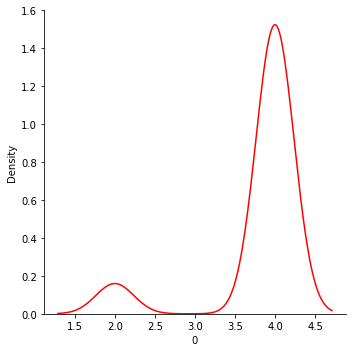

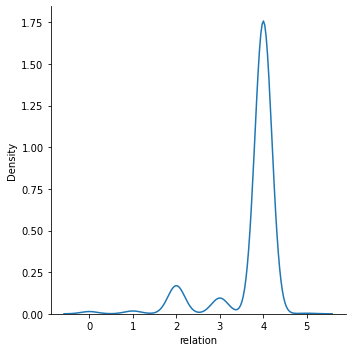

In [77]:
#visualize workclassMissing and workclass nonMissing 
sns.set
sns.displot(workclassMissing, x=0, kind = 'kde', color = 'r')
sns.displot(autism_data, x=y_train, kind ='kde')
 
# visualizing illustration
plt.show()

In [78]:
X_test['relation'] = y_pred
X_test

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
4,2,24.0,0,1,0,0,22,0,0,0,4.0
12,6,0.0,0,1,0,0,9,0,0,0,4.0
13,4,0.0,1,1,0,0,7,0,0,0,4.0
14,4,0.0,0,1,0,0,3,0,0,0,2.0
19,3,17.0,1,0,1,0,62,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
652,1,16.0,0,1,0,0,64,0,0,0,4.0
658,3,27.0,1,0,0,0,8,0,0,0,4.0
659,8,28.0,1,0,0,0,47,0,0,1,4.0
666,1,40.0,1,0,0,0,32,0,0,0,2.0


In [79]:
autism1 = pd.concat([autism_train,X_test])

In [80]:
autism1.sort_index(inplace=True)
autism1.head()

,result,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,Class/ASD,relation
0,6,9.0,0,1,0,0,64,0,0,0,4.0
1,5,7.0,1,0,0,1,13,0,0,0,4.0
2,8,10.0,1,0,1,1,56,0,0,1,2.0
3,6,18.0,0,1,0,1,64,0,0,0,4.0
4,2,24.0,0,1,0,0,22,0,0,0,4.0


In [24]:
#--------------------------------------------END OF 1ST LOOP---------------------------------------------------------------

In [81]:
autism1 = autism1[['gender','ethnicity','jundice','austim','contry_of_res','used_app_before','result','age_desc','relation','Class/ASD','age']]
autism1.head()

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
0,0,1,0,0,64,0,6,0,4.0,0,9.0
1,1,0,0,1,13,0,5,0,4.0,0,7.0
2,1,0,1,1,56,0,8,0,2.0,1,10.0
3,0,1,0,1,64,0,6,0,4.0,0,18.0
4,0,1,0,0,22,0,2,0,4.0,0,24.0


In [82]:
autism1_test = autism1[autism1['age'].isnull()]
autism1_test

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
6,0,0,0,0,64,0,2,0,4.0,0,NaN
9,1,0,1,1,9,0,8,0,0.0,1,NaN
15,1,0,0,1,43,0,6,0,2.0,0,NaN
23,1,0,1,0,62,0,2,0,3.0,0,NaN
27,1,0,1,1,0,0,1,0,2.0,0,NaN
62,1,0,0,0,52,0,0,0,4.0,0,NaN
91,0,1,0,0,36,0,4,0,4.0,0,NaN
196,1,1,0,0,64,0,10,0,4.0,1,NaN
197,1,1,0,0,26,0,9,0,4.0,1,NaN
203,0,1,0,1,64,0,9,0,3.0,1,NaN


In [83]:
X1_test = autism1_test.drop('age',axis=1)
X1_test

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
6,0,0,0,0,64,0,2,0,4.0,0
9,1,0,1,1,9,0,8,0,0.0,1
15,1,0,0,1,43,0,6,0,2.0,0
23,1,0,1,0,62,0,2,0,3.0,0
27,1,0,1,1,0,0,1,0,2.0,0
62,1,0,0,0,52,0,0,0,4.0,0
91,0,1,0,0,36,0,4,0,4.0,0
196,1,1,0,0,64,0,10,0,4.0,1
197,1,1,0,0,26,0,9,0,4.0,1
203,0,1,0,1,64,0,9,0,3.0,1


In [84]:
autism1_train = autism1.dropna(subset = ['age'])
autism1_train

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
0,0,1,0,0,64,0,6,0,4.0,0,9.0
1,1,0,0,1,13,0,5,0,4.0,0,7.0
2,1,0,1,1,56,0,8,0,2.0,1,10.0
3,0,1,0,1,64,0,6,0,4.0,0,18.0
4,0,1,0,0,22,0,2,0,4.0,0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
699,0,1,0,0,51,0,7,0,4.0,1,8.0
700,1,0,0,0,40,0,3,0,2.0,0,17.0
701,0,1,0,0,51,0,7,0,4.0,1,7.0
702,1,0,0,0,47,0,6,0,4.0,0,18.0


In [85]:
X1_train = autism1_train.drop('age',axis=1)
X1_train

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,0,1,0,0,64,0,6,0,4.0,0
1,1,0,0,1,13,0,5,0,4.0,0
2,1,0,1,1,56,0,8,0,2.0,1
3,0,1,0,1,64,0,6,0,4.0,0
4,0,1,0,0,22,0,2,0,4.0,0
...,...,...,...,...,...,...,...,...,...,...
699,0,1,0,0,51,0,7,0,4.0,1
700,1,0,0,0,40,0,3,0,2.0,0
701,0,1,0,0,51,0,7,0,4.0,1
702,1,0,0,0,47,0,6,0,4.0,0


In [86]:
y1_train = autism1_train['age']
y1_train

0       9.0
1       7.0
2      10.0
3      18.0
4      24.0
       ... 
699     8.0
700    17.0
701     7.0
702    18.0
703     9.0
Name: age, Length: 688, dtype: float64

In [87]:
#HistGradient classifier (only classifier that works with NaN values)
from sklearn.ensemble import HistGradientBoostingClassifier
clf1 = HistGradientBoostingClassifier().fit(X1_train, y1_train)

In [88]:
y1_pred = clf1.predict(X1_test)

In [89]:
#convert to Dataframe in order to visualize
occupationMissing = pd.DataFrame(y1_pred)
occupationMissing

,0
0,19.0
1,1.0
2,0.0
3,1.0
4,8.0
5,3.0
6,4.0
7,31.0
8,4.0
9,23.0


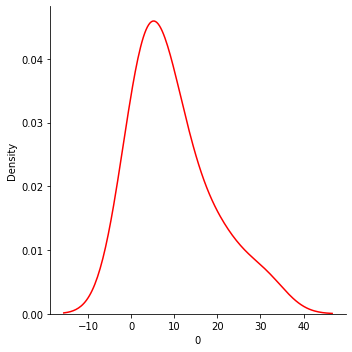

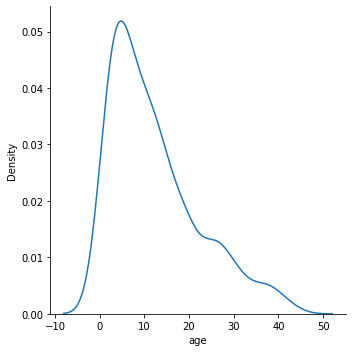

In [90]:
#visualize occupation and occupation nonMissing 
sns.set
sns.displot(occupationMissing, x=0, kind = 'kde', color = 'r')
sns.displot(autism1, x=y1_train, kind ='kde')
 
# visualizing illustration
plt.show()

In [91]:
X1_test['age'] = y1_pred
X1_test

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
6,0,0,0,0,64,0,2,0,4.0,0,19.0
9,1,0,1,1,9,0,8,0,0.0,1,1.0
15,1,0,0,1,43,0,6,0,2.0,0,0.0
23,1,0,1,0,62,0,2,0,3.0,0,1.0
27,1,0,1,1,0,0,1,0,2.0,0,8.0
62,1,0,0,0,52,0,0,0,4.0,0,3.0
91,0,1,0,0,36,0,4,0,4.0,0,4.0
196,1,1,0,0,64,0,10,0,4.0,1,31.0
197,1,1,0,0,26,0,9,0,4.0,1,4.0
203,0,1,0,1,64,0,9,0,3.0,1,23.0


In [92]:
autism2 = pd.concat([autism1_train,X1_test])
autism2.head(10)

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
0,0,1,0,0,64,0,6,0,4.0,0,9.0
1,1,0,0,1,13,0,5,0,4.0,0,7.0
2,1,0,1,1,56,0,8,0,2.0,1,10.0
3,0,1,0,1,64,0,6,0,4.0,0,18.0
4,0,1,0,0,22,0,2,0,4.0,0,24.0
5,1,0,1,0,64,0,9,0,4.0,1,19.0
7,1,1,0,0,43,0,5,0,2.0,0,44.0
8,1,1,0,0,64,0,6,0,4.0,0,12.0
10,1,1,0,0,64,0,10,0,3.0,1,16.0
11,0,0,0,0,14,0,6,0,2.0,0,1.0


In [93]:
autism2.sort_index(inplace=True)
autism2.head()

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD,age
0,0,1,0,0,64,0,6,0,4.0,0,9.0
1,1,0,0,1,13,0,5,0,4.0,0,7.0
2,1,0,1,1,56,0,8,0,2.0,1,10.0
3,0,1,0,1,64,0,6,0,4.0,0,18.0
4,0,1,0,0,22,0,2,0,4.0,0,24.0


In [94]:
#------------------------------------------- END OF 2ND LOOP -------------------------------------------------------------------

In [126]:
autism_check_missing = (autism2.isnull()).sum()
autism_check_missing

gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
age                0
dtype: int64

In [130]:
#privileged_groups = [{'gender' :1}]
#unprivileged_groups = [{'gender' :0}]
privileged_groups = [{'ethnicity' :1}]
unprivileged_groups = [{'ethnicity' : 0}]

In [131]:
#Convert to BinaryLabelDataset to compute fair metrics
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= autism2,
    label_names = ['Class/ASD'],
    protected_attribute_names=['ethnicity'])

In [138]:
#SPD calculation
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
# Load and create explainers

text_exp_otr = MetricTextExplainer(metric_orig_train)
# Print statistical parity difference
print(text_exp_otr.statistical_parity_difference())

Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.2761520737327189


In [139]:
# Putting independent variables/features to X
x = autism2.drop('Class/ASD',axis=1)
# Putting response/dependent variable/feature to y
Y = autism2['Class/ASD']

In [140]:
# Splitting the data into train and test
x_train,x_test,Y_train,Y_test = train_test_split(x,Y,test_size=0.25)


In [141]:
models = []
#models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))
models.append(('HGB', HistGradientBoostingClassifier()))

In [142]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [143]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_results = cross_val_score(model, x_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.901343 (0.032537)
NB: 0.935486 (0.017382)
CART: 1.000000 (0.000000)
RF: 1.000000 (0.000000)
SVM: 0.825544 (0.037154)
HGB: 1.000000 (0.000000)


In [111]:
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(x_train,Y_train)
# predictions
rfc_predict = rfc.predict(x_test)

In [112]:
#Hist_Based model training
hgb_classifier = HistGradientBoostingClassifier()
hgb_classifier.fit(x_train,Y_train)
y_pred_hgb = hgb_classifier.predict(x_test)

In [113]:
#classification report and confussion matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, y_pred_hgb))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, y_pred_hgb))

=== Confusion Matrix ===
[[137   0]
 [  0  39]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00        39

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



In [114]:
from sklearn import metrics
Sensitivity_recall = metrics.recall_score(Y_test, y_pred_hgb)
print({"Sensitivity":Sensitivity_recall})

{'Sensitivity': 1.0}


In [115]:
x_test = pd.concat([x_test,Y_test],axis=1)
x_test

,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,age,Class/ASD
611,1,0,0,0,29,0,4,0,4.0,7.0,0
250,1,0,0,0,43,0,3,0,4.0,25.0,0
388,0,0,0,0,36,0,4,0,4.0,3.0,0
674,0,1,1,0,20,0,6,0,4.0,10.0,0
53,1,0,0,1,13,0,8,0,4.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...
472,0,0,0,0,43,0,4,0,4.0,6.0,0
213,0,1,0,0,64,0,4,0,4.0,17.0,0
474,0,0,0,0,57,0,4,0,4.0,10.0,0
34,0,1,0,0,55,0,10,0,4.0,1.0,1


In [117]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df= x_test,
    label_names=['Class/ASD'],
    protected_attribute_names=['gender'])

In [118]:
from aif360.metrics import BinaryLabelDatasetMetric

def fair_metrics(binaryLabelDataset, y_pred_hgb):
    dataset_pred = binaryLabelDataset.copy()
    dataset_pred.labels = y_pred_hgb
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference()}
        
    return result


fair_metrics(binaryLabelDataset, y_pred_hgb)

{'statistical_parity_difference': 0.12786630392537893}

In [119]:
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_train = BinaryLabelDatasetMetric(binaryLabelDataset,unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Staistical Parity Difference between unprivileged and privileged groups = %f" % metric_orig_train.statistical_parity_difference())

#### Original training dataset

Staistical Parity Difference between unprivileged and privileged groups = 0.127866


In [121]:
rfc = RandomForestClassifier(n_estimators=600, max_depth=300, max_features='sqrt')
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').